In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

In [2]:
# Load dataset

dataset_zip = np.load('dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz',allow_pickle=True,encoding='bytes')

print('Keys in the dataset:', dataset_zip.keys())
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata']


print('Metadata: \n', metadata)

Keys in the dataset: KeysView(<numpy.lib.npyio.NpzFile object at 0x00000189B15915E0>)
Metadata: 
 {b'date': b'April 2017', b'description': b'Disentanglement test Sprites dataset.Procedurally generated 2D shapes, from 6 disentangled latent factors.This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite. All possible variations of the latents are present. Ordering along dimension 1 is fixed and can be mapped back to the exact latent values that generated that image.We made sure that the pixel outputs are different. No noise added.', b'version': 1, b'latents_names': (b'color', b'shape', b'scale', b'orientation', b'posX', b'posY'), b'latents_possible_values': {b'orientation': array([0.        , 0.16110732, 0.32221463, 0.48332195, 0.64442926,
       0.80553658, 0.96664389, 1.12775121, 1.28885852, 1.44996584,
       1.61107316, 1.77218047, 1.93328779, 2.0943951 , 2.25550242,
       2.41660973, 2.57771705, 2.73882436, 2.89993168, 3.061039  ,
       

In [3]:

# Define number of values per latents and functions to convert to indices
latents_sizes = metadata.item()[b'latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],np.array([1,])))

def latent_to_index(latents):
  return np.dot(latents, latents_bases).astype(int)


def sample_latent(size=1):
  samples = np.zeros((size, latents_sizes.size))
  for lat_i, lat_size in enumerate(latents_sizes):
    samples[:, lat_i] = np.random.randint(lat_size, size=size)

  return samples

In [4]:
# Helper function to show images
def show_images_grid(imgs_, num_images=25):
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')

def show_density(imgs):
  _, ax = plt.subplots()
  ax.imshow(imgs.mean(axis=0), interpolation='nearest', cmap='Greys_r')
  ax.grid('off')
  ax.set_xticks([])
  ax.set_yticks([])
     

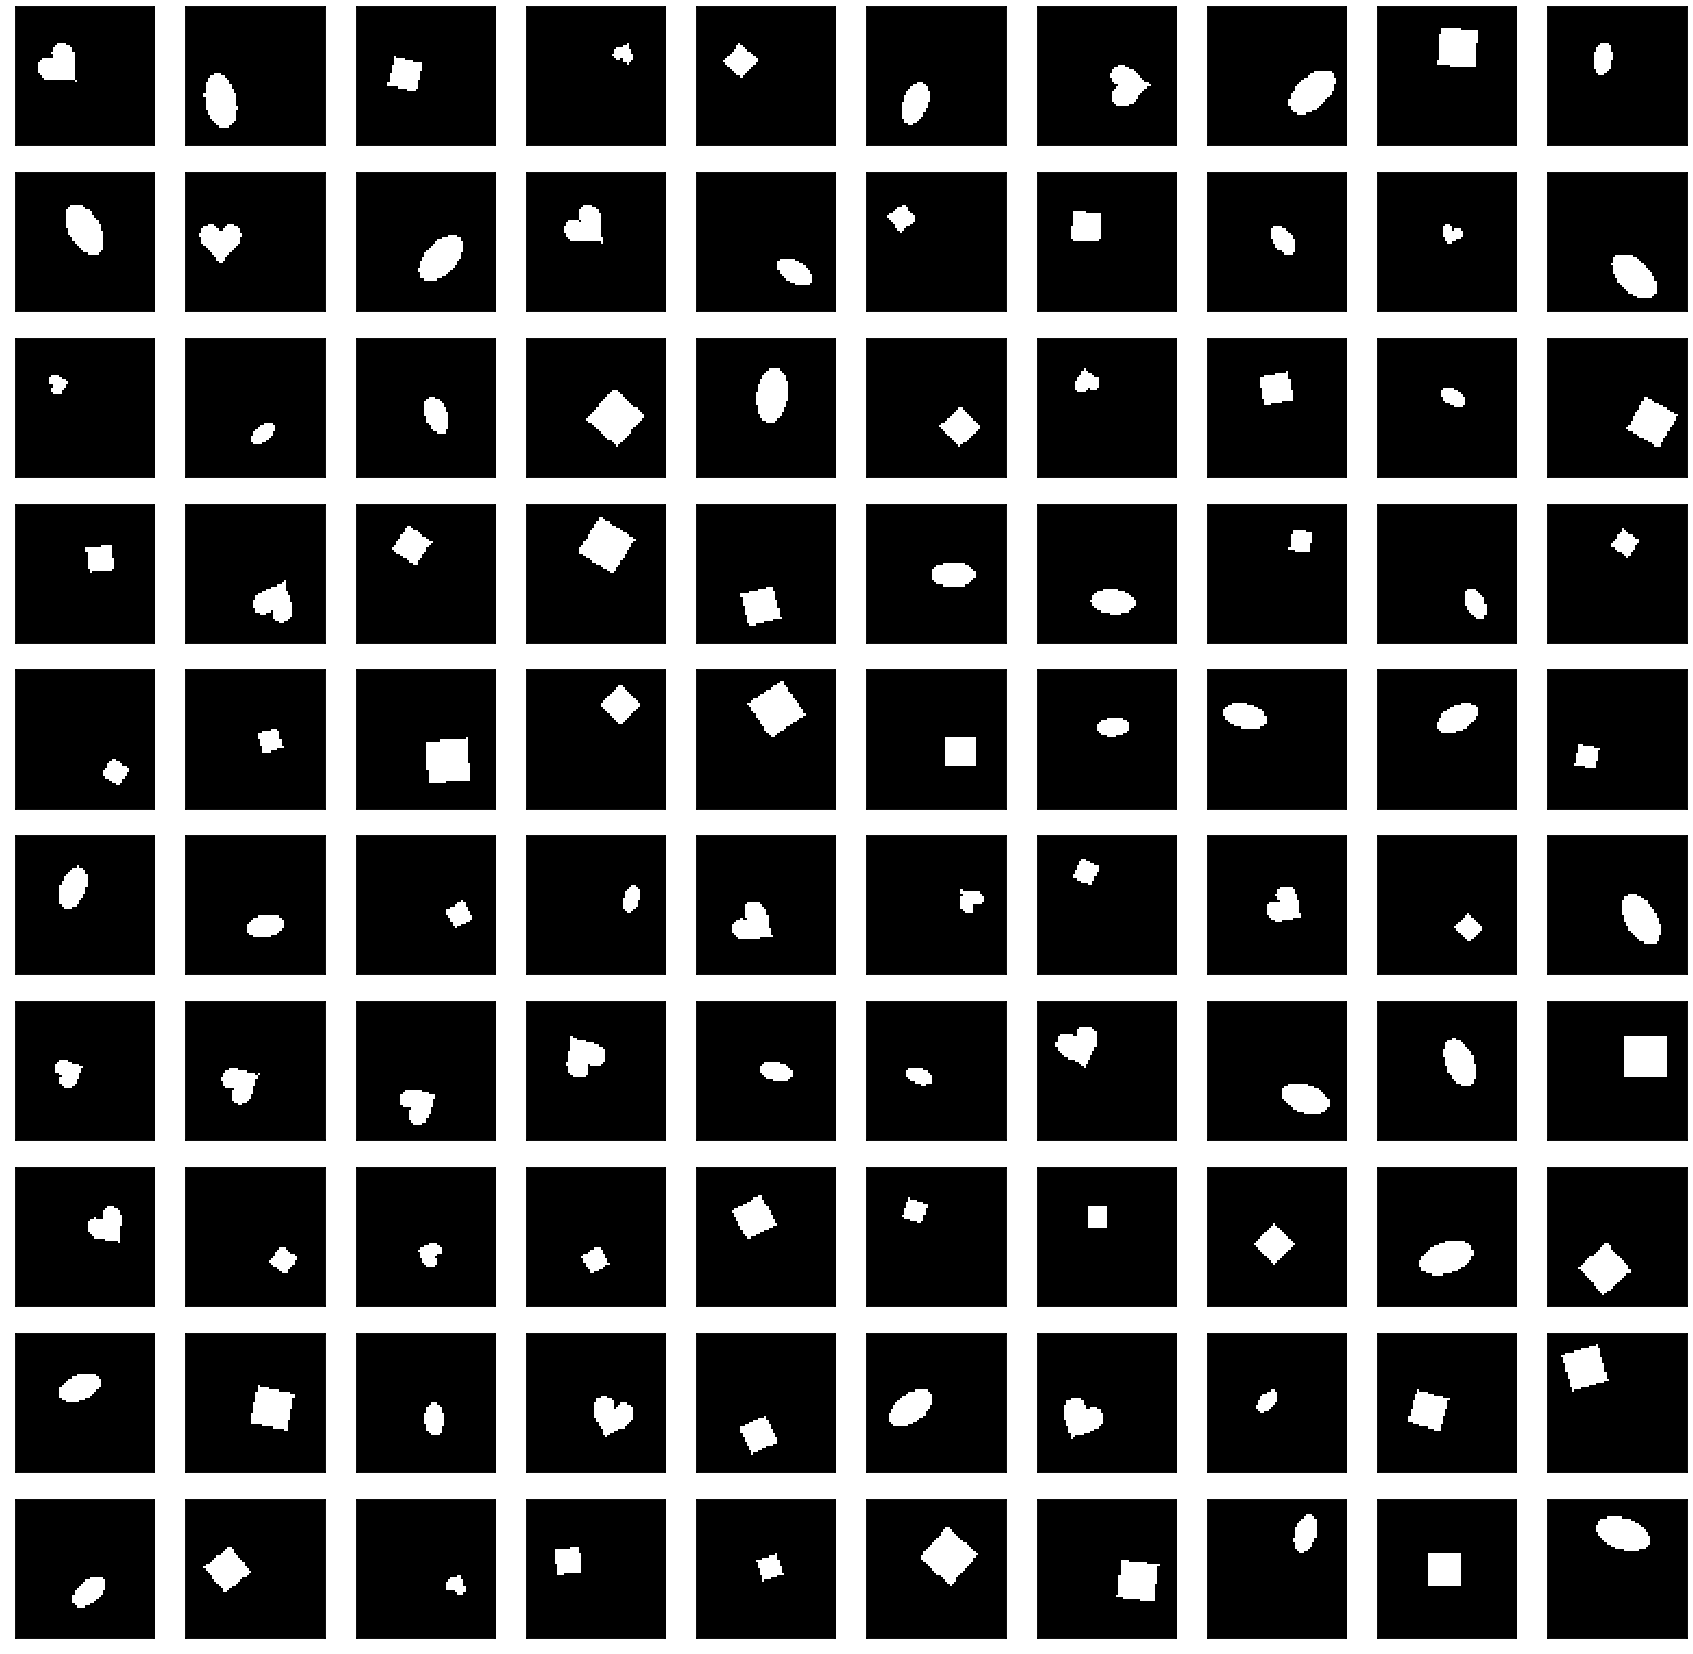

In [5]:
# Sample latents randomly
latents_sampled = sample_latent(size=5000)

# Select images
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

# Show images
show_images_grid(imgs_sampled,100)

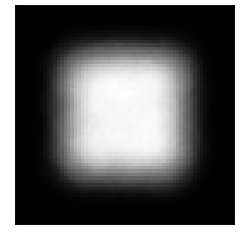

In [6]:
show_density(imgs_sampled)

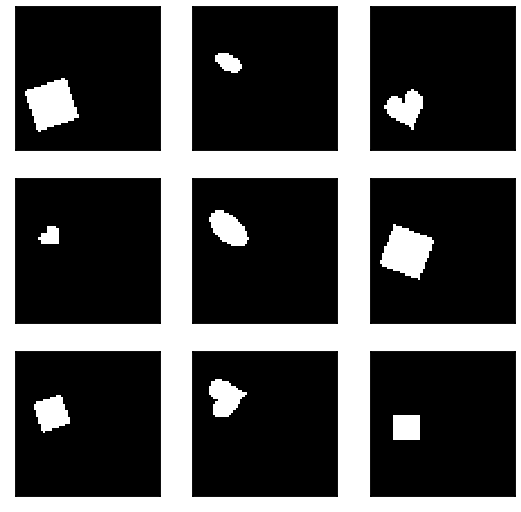

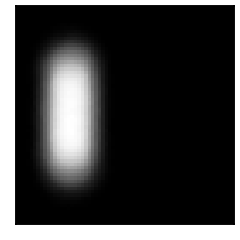

In [7]:
## Fix posX latent to left
latents_sampled = sample_latent(size=5000)
latents_sampled[:, -2] = 0
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

# Samples
show_images_grid(imgs_sampled, 9)

# Show the density too to check
show_density(imgs_sampled)

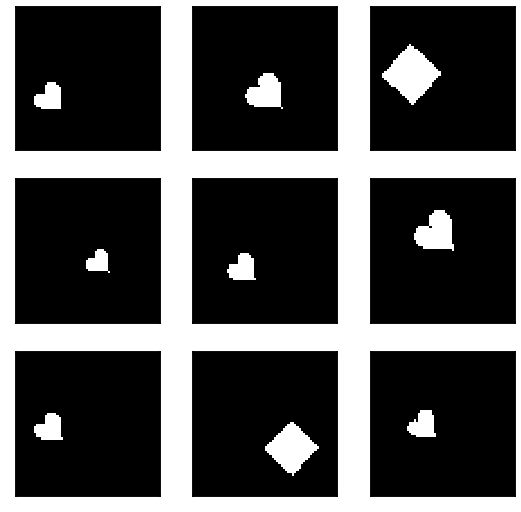

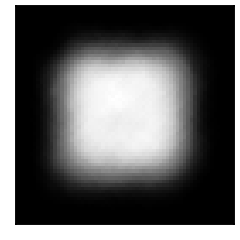

In [8]:

## Fix orientation to 0.8 rad
latents_sampled = sample_latent(size=5000)
latents_sampled[:, 3] = 5
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

# Samples
show_images_grid(imgs_sampled, 9)

# Density should not be different than for all orientations
show_density(imgs_sampled)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
from tqdm import tqdm
import torchvision.datasets as datasets  
from torch.utils.data import DataLoader 

In [10]:
X  = np.reshape(imgs,(-1,64*64))

In [15]:
class VAE(nn.Module):
    def __init__(self, input_dim, z_dim, h_dim):
        super().__init__()
        self.encoder_net = nn.Linear(input_dim,h_dim)
        self.mu_net = nn.Linear(h_dim,z_dim)
        self.sigma_net = nn.Linear(h_dim,z_dim)
        self.decoder_net = nn.Linear(z_dim, h_dim)
        self.output_net = nn.Linear(h_dim, input_dim)

        
    def encode(self,x):
        h = F.relu(self.encoder_net(x))
        mu = self.mu_net(h)
        sigma = torch.exp(self.sigma_net(h))
        return mu, sigma
    
    def decode(self, z):
        h_decode = F.relu(self.decoder_net(z))
        x = F.relu(self.output_net(h_decode))
        return x
    
    def forward(self, x):
        mu, sigma = self.encode(x)
        epsilon = torch.randn(mu.size())
        z_reparam = mu + sigma*epsilon
        x = self.decode(z_reparam.detach())
        return x, mu, sigma
    
model = VAE(64*64,50,200)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss() 

In [16]:


params = {'batch_size': 50000,
          'shuffle': True}

training_generator = torch.utils.data.DataLoader(torch.from_numpy(X.astype('float32')),**params)


In [17]:
beta = 1
for epoch in range(3):
    for batch_id, x in enumerate(training_generator):
        x_reconst, mu, sigma = model(x)
        reconst_loss = loss_fn(x,x_reconst)
        kl_div = torch.mean( -0.5* torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2),dim=1) )
        loss = reconst_loss + beta*kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print("epoch id: {}, step: {}, loss: {}, reconst_loss : {}, kl_div : {}".format(epoch,batch_id,loss.item(), reconst_loss.item(), kl_div.item()))

epoch id: 0, step: 0, loss: 0.3917628526687622, reconst_loss : 0.06410841643810272, kl_div : 0.3276544511318207
epoch id: 0, step: 1, loss: 0.2807084321975708, reconst_loss : 0.05691070854663849, kl_div : 0.22379770874977112
epoch id: 0, step: 2, loss: 0.15729105472564697, reconst_loss : 0.05185789614915848, kl_div : 0.10543316602706909
epoch id: 0, step: 3, loss: 0.12250738590955734, reconst_loss : 0.04855148494243622, kl_div : 0.07395590096712112
epoch id: 0, step: 4, loss: 0.11204895377159119, reconst_loss : 0.04618808627128601, kl_div : 0.06586086750030518
epoch id: 0, step: 5, loss: 0.10532522201538086, reconst_loss : 0.04466959834098816, kl_div : 0.0606556236743927
epoch id: 0, step: 6, loss: 0.09849879890680313, reconst_loss : 0.043526336550712585, kl_div : 0.054972462356090546
epoch id: 0, step: 7, loss: 0.091932013630867, reconst_loss : 0.042931556701660156, kl_div : 0.04900046065449715
epoch id: 0, step: 8, loss: 0.08560521900653839, reconst_loss : 0.0424010269343853, kl_div 

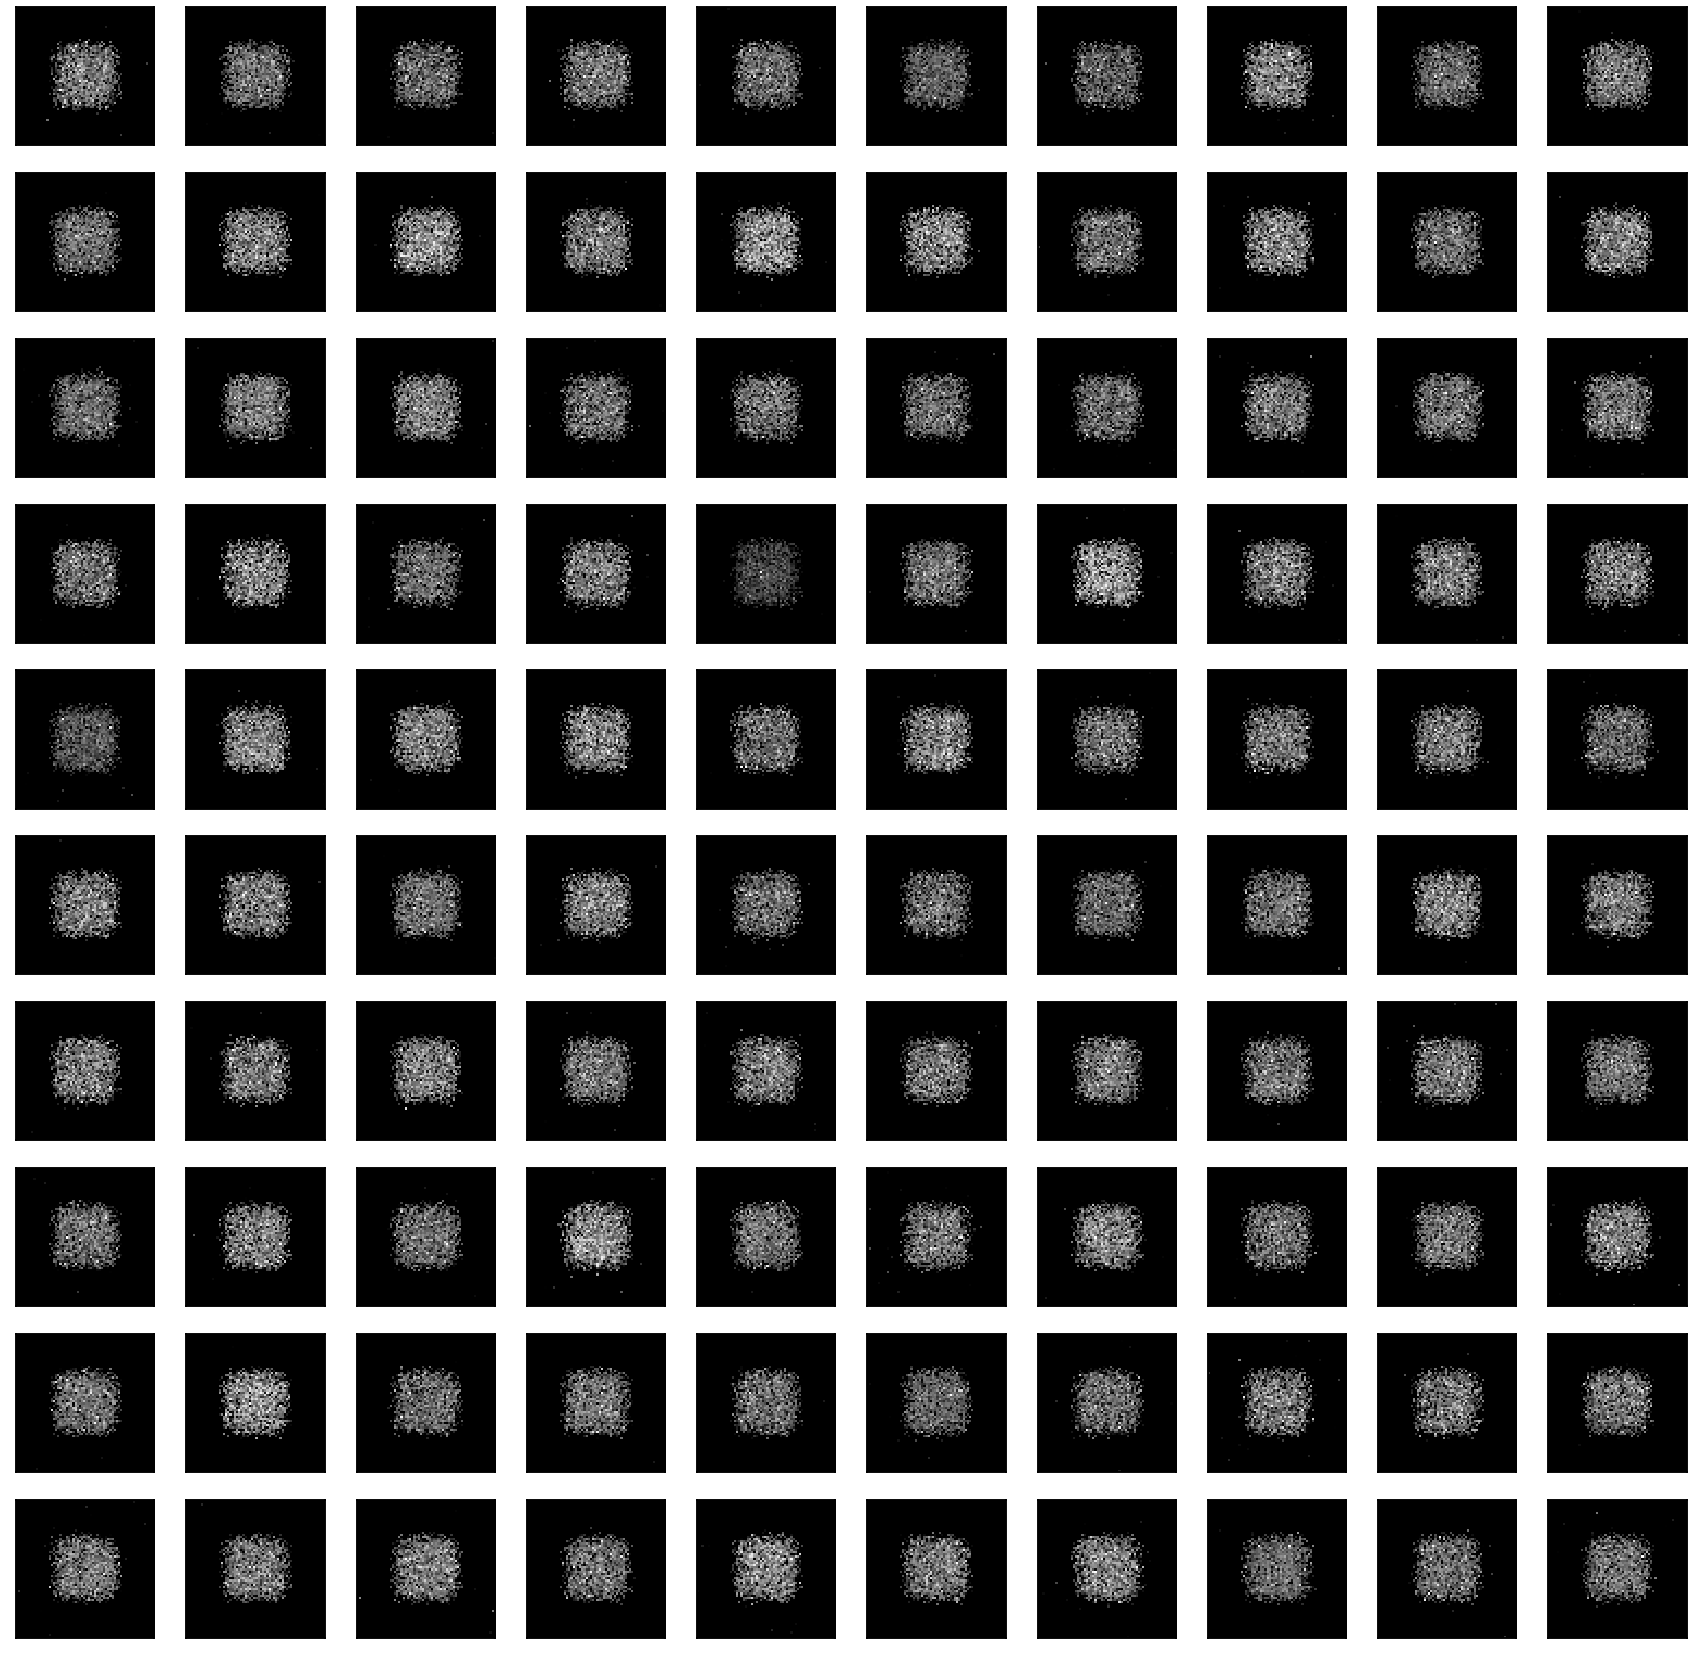

In [18]:
z = torch.randn((100,50))
y = model.decode(z).detach().numpy()
X_gen  = np.reshape(y,(-1,64,64))


# Show images
show_images_grid(X_gen,100)